### IMPORTS

In [18]:
from Inference.VariationalGNN import GNN


In [1]:
import torch
from torch import nn
from torch import functional as F
import matplotlib.pyplot as plt
import numpy as np
from livelossplot import PlotLosses
from Tools.NNtools import *

In [14]:
target_mixture = [torch.distributions.normal.Normal(4.4, 0.4),
           torch.distributions.normal.Normal(.0, 2.5),
           torch.distributions.normal.Normal(2.0, 1.0)]
target_proportions = torch.tensor([0.05, 0.35, 0.6])


In [15]:
def target(x):
    return torch.exp(logtarget(x))

def logtarget(x):
    logp = [None]*len(target_mixture)
    for j in range(len(target_mixture)):
        logp[j] = target_mixture[j].log_prob(x) + target_proportions[j].log()
    return torch.logsumexp(torch.cat(logp,dim=1),dim=1).unsqueeze(-1)

<IPython.core.display.Javascript object>


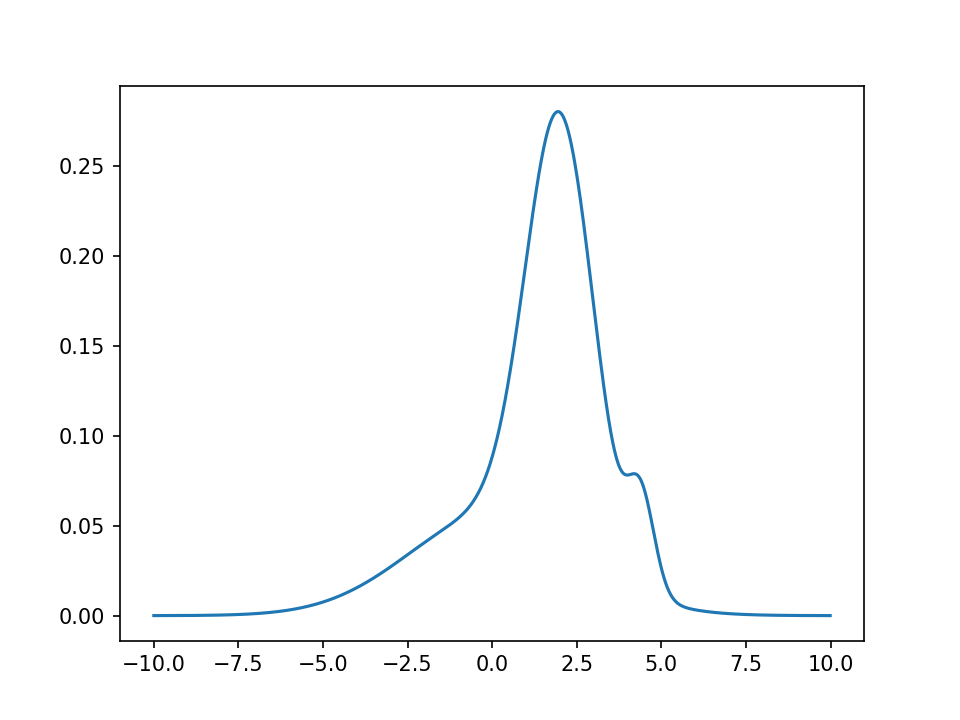

In [16]:
%matplotlib notebook
%matplotlib notebook

x_lin = torch.arange(-10, 10.0, 0.01).unsqueeze(-1)
plt.plot(x_lin.detach().cpu().numpy(), target(x_lin).detach().cpu().numpy())


In [19]:
G=GNN(10,10,1,sigma=1.,layers=3,activation=nn.ReLU)
print('%%% Submodules %%%')
for i in G.named_modules():
    print(i)
print('%%% Parameters %%%')
for i in G.named_parameters():
    print(i)


%%% Submodules %%%
('', GNN(
  (transformer): Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=10, bias=True)
    (5): ReLU()
    (6): Linear(in_features=10, out_features=1, bias=True)
  )
))
('transformer', Sequential(
  (0): Linear(in_features=10, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=10, bias=True)
  (3): ReLU()
  (4): Linear(in_features=10, out_features=10, bias=True)
  (5): ReLU()
  (6): Linear(in_features=10, out_features=1, bias=True)
))
('transformer.0', Linear(in_features=10, out_features=10, bias=True))
('transformer.1', ReLU())
('transformer.2', Linear(in_features=10, out_features=10, bias=True))
('transformer.3', ReLU())
('transformer.4', Linear(in_features=10, out_features=10, bias=True))
('transformer.5', ReLU())
('transformer.6', Linear(in_features=10, out_features=1,

In [20]:
def init_weightsOut(m):
    if type(m) == nn.Linear:
        torch.nn.init.normal_(m.weight,mean=0., std=5.)
        torch.nn.init.constant_(m.bias,0.)

#for c in range(G.nb_comp)
        
G.transformer[6].apply(init_weightsOut)



Linear(in_features=10, out_features=1, bias=True)

In [21]:
x_lin.shape[0]
G.KDE(x_lin,10).shape
#x_lin.shape
#target(x_lin)

torch.Size([2000, 1])

<IPython.core.display.Javascript object>


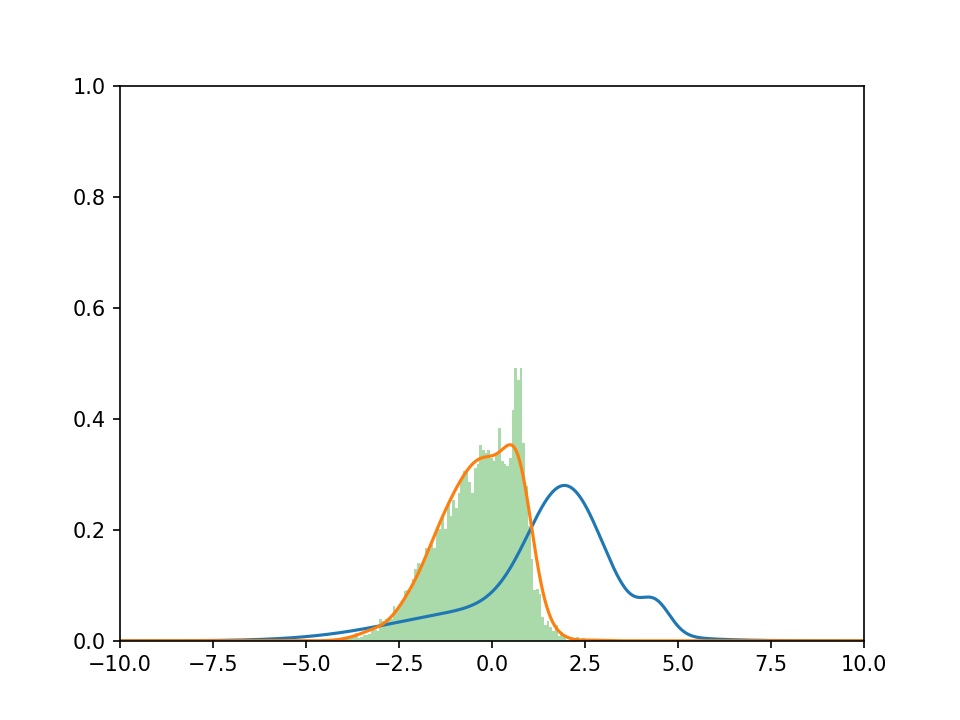

In [22]:
%matplotlib notebook
%matplotlib notebook
import seaborn as sns


x_lin = torch.arange(-10, 10.0, 0.01).unsqueeze(-1)
plt.plot(x_lin.detach().cpu().numpy(), target(x_lin).detach().cpu().numpy())
plt.plot(x_lin.detach().cpu().numpy(), G.KDE(x_lin,1000).exp().detach().cpu().numpy())

ax = sns.distplot(G(10000).detach().numpy(), bins=100, norm_hist =True, kde=False)

ax.set_xlim(-10,10)

ax.set_ylim(0,1)
ax.set_label(['target','KDE','histo'])


In [26]:
GNN_optimizer = torch.optim.Adam(G.parameters(), lr=.00001)
GNN_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(GNN_optimizer, patience=50, factor=0.5)
%matplotlib inline
liveloss = PlotLosses()

In [31]:
n_samples_KDE=1000
n_samples_VAR=2000

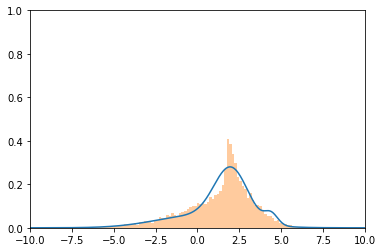

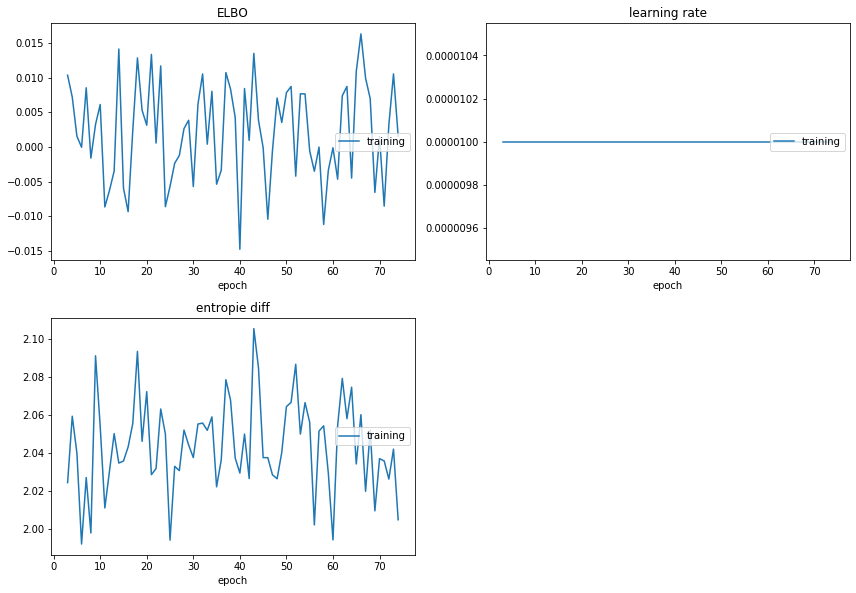

ELBO:
training   (min:   -0.015, max:    0.016, cur:    0.002)

learning rate:
training   (min:    0.000, max:    0.000, cur:    0.000)

entropie diff:
training   (min:    1.992, max:    2.106, cur:    2.005)


KeyboardInterrupt: 

In [32]:
%matplotlib inline
for t in range(10000):
    logs = {}
    GNN_optimizer.zero_grad()

    learning_rate = GNN_optimizer.param_groups[0]['lr']
    
    theta=G(n_samples_VAR)
    ED=G.KDE(theta,n_samples_KDE).mean()
    LP=logtarget(theta).mean()
    L =ED-LP 

    L.backward()
    

    

    GNN_scheduler.step(L.detach().clone().cpu().numpy())

    logs['ELBO'] = L.detach().clone().cpu().numpy()
    logs['learning rate'] = learning_rate
    logs['entropie diff'] = -ED.detach().clone().cpu().numpy()
    liveloss.update(logs)

   
    
    if t % 2 == 0:
        x_lin = torch.arange(-10, 10.0, 0.01).unsqueeze(-1)
        plt.plot(x_lin.detach().cpu().numpy(), target(x_lin).detach().cpu().numpy())

        ax = sns.distplot(G(10000).detach().numpy(), bins=100, norm_hist =True, kde=False)
        ax.set_xlim(-10,10)
        ax.set_ylim(0,1)

        liveloss.draw()

    GNN_optimizer.step()

    if learning_rate < 0.00000001:
        break